# Import the data
We want the doubletannotation.csv as the label file.
The pbmc_expr.csv can be the x 
doubletannotation.csv can be the y

In [ ]:
!python -m pip install 'fsspec>=0.3.3'
!python -m pip install dask[dataframe] --upgrade  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
test_data = 0
train_data = 0
val_data = 0


In [ ]:
# import required modules
import pandas as pd
import numpy as np
import time
from dask import dataframe as df1
  
# time taken to read data
s_time_dask = time.time()
dask_df = df1.read_csv('pbmc_expr.csv', assume_missing=True)
e_time_dask = time.time()
  
print("Read with dask: ", (e_time_dask-s_time_dask), "seconds")
  
# data
dask_df.head(1)

Read with dask:  8.11897873878479 seconds


,Unnamed: 0,AAACAGCCAAAGCCTC.1,AAACAGCCAGAATGAC.1,AAACAGCCAGCTACGT.1,AAACAGCCAGGCCTTG.1,AAACAGCCATAAGGAC.1,AAACAGCCATAATGTC.1,AAACATGCAGCAATAA.1,AAACATGCAGCCAGAA.1,AAACATGCAGGCGATA.1,...,TTTGTGGCATGAATCT.1,TTTGTGTTCAGTTCCC.1,TTTGTGTTCCCTCATA.1,TTTGTGTTCCTTGAGG.1,TTTGTGTTCTAGCTAA.1,TTTGTTGGTACGCGCA.1,TTTGTTGGTATTTGCC.1,TTTGTTGGTGATTACG.1,TTTGTTGGTTTCAGGA.1,TTTGTTGGTTTCCACG.1
0,MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dialect = 0
with open('pbmc_expr.csv', newline='') as csvfile:
    dialect = csv.Sniffer().sniff(csvfile.read(1024))
    csvfile.seek(0)
    print(csvfile.seek(5))


5


In [ ]:

# import x
with open('pbmc_expr.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    reader
    for row in reader:
        print(', '.join(row))

# Eigener Dataloader 4 size

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms

class CustomDataloaderold(Dataset):
    def __init__(self, dast):
        self.dast = dast
        
    def __len__(self):
        return self.dast.index.stop
        
    def __getitem__(self, idx):
        entry = self.dast.iloc[idx]
        if type(idx) == slice:
          xent = np.vstack(entry.values[:,2:6]).astype(np.float)
          x = torch.from_numpy(xent).float()
          yent = np.vstack(entry.values[:,6:]).astype(np.float)
          y = torch.from_numpy(yent).float()
        else:
          x = torch.tensor(entry[2:6]).float()
          y = torch.tensor([float(int(i)) for i in entry[6:]]).float()
        return x, y

# Eigener Dataloader 103 size

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms

class CustomDataloader(Dataset):
    def __init__(self, dast):
        self.dast = dast
        
    def __len__(self):
        return self.dast.index.stop
        
    def __getitem__(self, idx):
        entry = self.dast.iloc[idx]
        if type(idx) == slice:
          xent = np.vstack(entry.values[:,:-3]).astype(np.float)
          x = torch.from_numpy(xent).float()
          yent = np.vstack(entry.values[:,-3:]).astype(np.float)
          y = torch.from_numpy(yent).float()
        else:
          x = torch.tensor(entry[:-3]).float()
          y = torch.tensor([float(int(i)) for i in entry[-3:]]).float()
        return x, y

# Loading data from csv

In [45]:
import torch
import numpy as np
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# import y and x
import csv
import pandas as pd
dataset_read = pd.read_csv('Doubletannotation.csv')  

# trimming the dataframe
dataset_read = dataset_read[["V1","bcds_s","cxds_s","dbf_s","chord","heterotypic","homotypic","singlet"]]


tempset = dataset_read
train_split = tempset.sample(frac=0.8).reset_index()
val_split = tempset.sample(frac=0.5).reset_index()
test_split = tempset.sample(frac=1).reset_index()

tt = train_split.to_numpy()
t0 = np.where(tt[:,0+6] == True)
t1 = np.where(tt[:,1+6] == True)
t2 = np.where(tt[:,2+6] == True)
t0set = tt[t0]
t1set = tt[t1]
t2set = tt[t2[0][:300]]
print(t0set.shape)
print(t1set.shape)
print(t2set.shape)
tset = np.concatenate((t0set, t1set), axis=0)
tset = np.concatenate((tset, t2set), axis=0)
np.random.shuffle(tset)
print(tset)
tset = pd.DataFrame(tset, columns=["idxs","V1","bcds_s","cxds_s","dbf_s","chord","heterotypic","homotypic","singlet"])
print(tset)


train_data = CustomDataloader(tset)#train_split)
val_data = CustomDataloader(val_split)
test_data = CustomDataloader(test_split)

loaders = {
    'train' : train_data, #torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'val' : val_data, #torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=True, num_workers=1),
    'test'  : test_data #torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}


print("Training data:" ,train_data)
print("Validation data:" ,val_data)
print("Testing data:" ,test_data)



cpu
(362, 9)
(290, 9)
(300, 9)
[[4865 'CGTCATTGTAGGTGTC.1' 0.773191750049591 ... True False False]
 [6858 'GCCGTGAGTGGTTCCC.1' 0.0421629399061203 ... False False True]
 [6681 'GCACTAAGTGGATTAT.1' 0.732089161872864 ... False True False]
 ...
 [1556 'AGCAACAAGGGTGAAC.1' 0.890693664550781 ... False True False]
 [2038 'AGTACGCGTTTCCGGC.1' 0.954596340656281 ... True False False]
 [4684 'CGGAATCGTTCCGGGA.1' 0.732701778411865 ... True False False]]
     idxs                  V1    bcds_s          cxds_s   dbf_s     chord  \
0    4865  CGTCATTGTAGGTGTC.1  0.773192   806126.806729  0.6125 -1.196678   
1    6858  GCCGTGAGTGGTTCCC.1  0.042163   207762.742497   0.025 -1.992952   
2    6681  GCACTAAGTGGATTAT.1  0.732089   279032.772917   0.175 -2.065139   
3    6855  GCCGTGAGTCAGTAAT.1  0.915708  1151176.904928  0.6125 -1.316453   
4    4976  CTAAAGCTCATAGCCG.1  0.020389   127844.357496   0.025 -1.994257   
..    ...                 ...       ...             ...     ...       ...   
947  1829  AGGA

# Loading Data from h5ad

In [174]:
import torch
import numpy as np
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# import y and x
import csv
import pandas as pd
dataset_read = pd.read_csv('pbmc_hvg_12012_100.csv')  

clist = []


for index, row in dataset_read.iterrows():
  if row[-1] == "singlet":
    clist.append([False, False, True])
  if row[-1] == "homo":
    clist.append([False, True, False])
  if row[-1] == "hetero":
    clist.append([True, False, False])

classes = pd.DataFrame(data = np.array(clist), columns=["hetero","homo","singlet"])
print(sum(classes["hetero"]))
print(sum(classes["homo"]))
print(sum(classes["singlet"]))
# print(classes)

print(dataset_read.shape)
dataset_read = dataset_read.drop(["Unnamed: 0",'obs',"cell_type"], axis=1)
print(dataset_read.shape)
dataset_read = dataset_read.join(classes)
print(dataset_read.shape)


tempset = dataset_read
train_split = tempset.sample(frac=0.8)
tempset = tempset.drop(train_split.index)
val_split = tempset.sample(frac=0.5)
tempset = tempset.drop(val_split.index)
test_split = tempset.sample(frac=1)
# tempset = tempset.drop(test_split.index)

train_split.reset_index()
val_split.reset_index()
test_split.reset_index()

tt = train_split.to_numpy()
t0 = np.where(tt[:,-3] == True)
t1 = np.where(tt[:,-2] == True)
t2 = np.where(tt[:,-1] == True)
t0set = tt[t0]
t1set = tt[t1]
t2set = tt[t2[0][:400]]
print(t0set.shape)
print(t1set.shape)
print(t2set.shape)
tset = np.concatenate((t0set, t1set), axis=0)
tset = np.concatenate((tset, t2set), axis=0)
temp_var = tset
# tset = tset[:,1:] # eliminate index column
np.random.shuffle(tset)

tset = pd.DataFrame(tset, columns=dataset_read.columns.values)#[1:])
# print(tset.columns.values)

# print(val_split.columns.values)
# val_split = val_split.drop(["index"], axis=1)
# test_split = test_split.drop(["index"], axis=1)

print(tset.shape)

train_data = CustomDataloader(tset)#train_split)
val_data = CustomDataloader(val_split)
test_data = CustomDataloader(test_split)

loaders = {
    'train' : train_data, #torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'val' : val_data, #torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=True, num_workers=1),
    'test'  : test_data #torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}


print("Training data:" ,train_data)
print("Validation data:" ,val_data)
print("Testing data:" ,test_data)


print("Training data:" ,tset.shape)
print("Validation data:" ,val_split.shape)
print("Testing data:" ,test_split.shape)

print(loaders["train"][0][0].shape)



cpu
455
361
11196
(12012, 103)
(12012, 100)
(12012, 103)
(381, 103)
(287, 103)
(400, 103)
(1068, 103)
Training data: <__main__.CustomDataloader object at 0x7f0b722bcc10>
Validation data: <__main__.CustomDataloader object at 0x7f0b722bc910>
Testing data: <__main__.CustomDataloader object at 0x7f0b722bc090>
Training data: (1068, 103)
Validation data: (1201, 103)
Testing data: (1201, 103)
torch.Size([100])


# Architectur




In [177]:


'''
in_channels (int) — Number of channels in the input image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) — If True, adds a learnable bias to the output. Default: True
'''


# https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

# hier gehts weiter

import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output#, x    # return x for visualization



# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_size, output_size):
        # super(ANNModel, self).__init__()
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, 64) 
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 8)
        self.fc4 = nn.Linear(8, 8)
        self.fcend = nn.Linear(8, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        # print(x.size())
        # print(x)
        # x = x.view(x.size(0), -1)       
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fcend(out)
        out = self.sig(out)
        # out = self.fc1(x)
        # out = self.fc2(out)
        # out = self.fc3(out)
        return out#.to(torch.float64)

In [ ]:
testt = torch.tensor([[[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]]])
print(testt)
print(testt.size())
print(testt.view(6,1))

# Early Stopping

In [4]:
import numpy as np
import torch

# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0.001, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_model = 0
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Accuracy increased ({1-self.val_loss_min:.6f} --> {1-val_loss:.6f}).  Saving model ...')
        self.best_model = model
        #torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Training debugging

In [ ]:
import torch.nn
from torch import optim
from torch.autograd import Variable

NeuralNet = ANNModel(4,3)
    # print(nnet)

num_epochs = 100

NeuralNet.train()

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=5, verbose=True)
    
# loss
loss_func = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(NeuralNet.parameters(), lr = 0.01)   


# Train the model
total_step = len(loaders['train'])
        
for epoch in range(num_epochs):
    NeuralNet.train()
    print(epoch)
    for images, labels in loaders['train']:
        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y
        
        output = NeuralNet(b_x.float())
                  
        loss = loss_func(output, b_y)
            
        # clear gradients for this training step   
        optimizer.zero_grad()           
            
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()                
        pass
    NeuralNet.eval()
    for data, labels in loaders['val']:
      test_output = NeuralNet(data.float())
      pred_y = torch.max(test_output,-1)[1]
      true_y = torch.max(labels,-1)[1]
      accuracy = int((pred_y == true_y).item())




torch.max(test_output)
test_output

# outputs = [0,0,0]
# print([int(i) for i in (test_output>=0.5).tolist()])
# outputs[test_output >= 0.5] = 1
# outputs[test_output < 0.5] = 0
pred_y = torch.max(test_output,-1)[1]
true_y = torch.max(labels,-1)[1]
accuracy = int((pred_y == true_y).item())
print(pred_y)
print(true_y)
print((pred_y == true_y).item())
print(accuracy)

In [ ]:
NeuralNet = ANNModel(4,3)
NeuralNet.train()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(NeuralNet.parameters(), lr = 0.01)   

point1, target1 = loaders["train"][0:2]
output = NeuralNet(point1.float())
loss = loss_func(output, target1)
# clear gradients for this training step   
NeuralNet.zero_grad()   

# print(loss)
print('fc1.weight before backward')
print(NeuralNet.fc1.weight[0])
loss.backward()
print('fc1.weight after backward')
print(NeuralNet.fc1.weight[0])            
optimizer.step()  
print('fc1.weight after step')
print(NeuralNet.fc1.weight[0])            


fc1.weight before backward
tensor([-0.3939,  0.0626, -0.4104, -0.1777], grad_fn=<SelectBackward0>)
fc1.weight after backward
tensor([-0.3939,  0.0626, -0.4104, -0.1777], grad_fn=<SelectBackward0>)
fc1.weight after step
tensor([-0.3939,  0.0626, -0.4104, -0.1777], grad_fn=<SelectBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
import torch.optim as optim
NeuralNet = ANNModel(4,3)
NeuralNet.train()
criterion = nn.MSELoss()
print(loaders["train"][0:2])
unpack = loaders["train"]
print(unpack[:])
point1, target1 = loaders["train"][0:2]
# create your optimizer
optimizer = optim.SGD(NeuralNet.parameters(), lr=0.01)
print(len(loaders["test"]))

# in your training loop:
print('fc1.weight before backward')
print(NeuralNet.fc1.weight[0])
optimizer.zero_grad()   # zero the gradient buffers
output = NeuralNet(point1)
print(output)
print(target1)
loss = criterion(output, target1)
test = NeuralNet.fc1.bias
# print("gradient: ", NeuralNet.fc1.bias)
loss.backward()
optimizer.step()    # Does the update
print('fc1.weight after step')
print(NeuralNet.fc1.weight[0]) 

(tensor([[ 2.7279e-02,  6.8598e+04,  2.5000e-02, -1.9943e+00],
        [ 3.1351e-02,  1.3335e+05,  1.1250e-01, -1.9835e+00]],
       dtype=torch.float64), tensor([[0., 0., 1.],
        [0., 0., 1.]], dtype=torch.float64))
(tensor([[ 2.7279e-02,  6.8598e+04,  2.5000e-02, -1.9943e+00],
        [ 3.1351e-02,  1.3335e+05,  1.1250e-01, -1.9835e+00],
        [ 5.7130e-02,  2.1423e+05,  2.2500e-01, -1.9150e+00],
        ...,
        [ 4.5890e-02,  2.0553e+05,  0.0000e+00, -1.9908e+00],
        [ 2.1363e-02,  2.7655e+05,  2.7500e-01, -1.8708e+00],
        [ 4.5804e-02,  1.8010e+05,  3.7500e-02, -1.9908e+00]],
       dtype=torch.float64), tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=torch.float64))
2402
fc1.weight before backward
tensor([-0.4072,  0.0744, -0.0804, -0.4936], grad_fn=<SelectBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


RuntimeError: ignored

In [ ]:
test = torch.tensor([[1,0],[0,1]])
np.where(test[:1] == 1)
#[where torch.tensor([1,0])[0] == 1]

(array([0]), array([0]))

In [ ]:
label = torch.tensor([[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],
                     [0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],
                     [1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]])

prediction = torch.tensor([[1,0,0],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],
                          [0,0,1],[0,0,1],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],
                          [0,1,0],[0,1,0],[0,1,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]])

indices_class0 = np.where(label[:0] == 1)
label_class0 = label[indices_class0]
prediction_class0 = prediction[indices_class0]
pred_y0 = torch.max(prediction_class0,-1)[1]
true_y0 = torch.max(label_class0,-1)[1]
accuracy0 = int((pred_y0 == true_y0).item())

indices_class1 = np.where(label[:1] == 1)
label_class1 = label[indices_class1]
prediction_class1 = prediction[indices_class1]
pred_y1 = torch.max(prediction_class1,-1)[1]
true_y1 = torch.max(label_class1,-1)[1]
accuracy1 = int((pred_y1 == true_y1).item())

indices_class2 = np.where(label[:2] == 1)
label_class2 = label[indices_class2]
prediction_class2 = prediction[indices_class2]
pred_y2 = torch.max(prediction_class2,-1)[1]
true_y2 = torch.max(label_class2,-1)[1]
accuracy2 = int((pred_y2 == true_y2).item())


SyntaxError: ignored

In [ ]:
import torch.nn as nn
from torch import optim
x1,y1 = loaders['train'][0]
x2,y2 = loaders['train'][1]
x3,y3 = loaders['train'][2]
model = nn.Linear(4, 3)
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

# Run training
niter = 10
for _ in range(0, niter):
	optimizer.zero_grad()
	predictions = model(x)
	loss = loss_fn(predictions, t)
	loss.backward()
	optimizer.step()

	print("-" * 10)
	print("learned a = {}".format(list(model.parameters())[0].data[0, 0]))
	print("learned b = {}".format(list(model.parameters())[1].data[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])


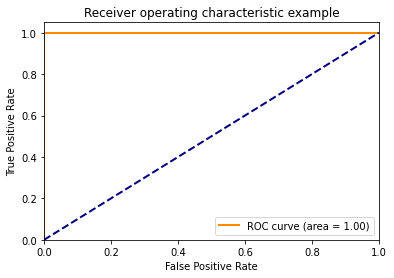

In [60]:
from torch import optim
x1,y1 = loaders['train'][0:10]
x2,y2 = loaders['train'][1]
x3,y3 = loaders['train'][2]
NeuralNet = ANNModel(4,3)
# NeuralNet.train()
optimizer = optim.Adam(NeuralNet.parameters(), lr = 0.01) 
criterion = nn.MSELoss()#weight=torch.tensor([1,1,0.02]))


weight_before = NeuralNet.fc1.weight[0]
# print(list(NeuralNet.parameters())[0].clone())
optimizer.zero_grad()
output = NeuralNet(x1)
# print(output)
loss = criterion(output, y1)
# print(x1,y1)
# print(loss.item())
loss.backward()
optimizer.step()
weight_after = NeuralNet.fc1.weight[0]
# print(weight_after-weight_before)
# print(list(NeuralNet.parameters())[0].clone())

print(y1)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y1[:, i].detach().numpy(), output[:, i].detach().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y1.detach().numpy().ravel(), output.detach().numpy().ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# Training

In [140]:
# useful code 
def acc_for_class(let_class, labels, predictions):
  indices_class = np.where(labels[:,let_class] == 1)
  label_class = labels[indices_class]
  prediction_class = predictions[indices_class]
  # print(prediction_class.shape)
  # print(label_class.shape)
  pred_y = torch.max(prediction_class,-1)[1]
  true_y = torch.max(label_class,-1)[1]
  accuracy = sum(pred_y == true_y).item()/pred_y.__len__()
  return accuracy

def save_csv(data, name):
  t_np = data.numpy() #convert to Numpy array
  df = pd.DataFrame(t_np) #convert to a dataframe
  df.to_csv(name+".csv",index=False) #save to file

def to_strings(matrix):
  strings = []
  for i in matrix:
    if i[0]:
      strings.append("hetero")
    if i[1]:
      strings.append("homo")
    if i[2]:
      strings.append("singlet")
  return strings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(0.6433)
tensor(0.7313)
tensor(0.6255)
0
Accuracy increased (-inf --> 0.463008).  Saving model ...
accuracy mean:  0.4630077668068906
1
Accuracy increased (0.463008 --> 0.520863).  Saving model ...
accuracy mean:  0.520862849379164
2
Accuracy increased (0.520863 --> 0.547040).  Saving model ...
accuracy mean:  0.5470404033799051
3
EarlyStopping counter: 1 out of 10
accuracy mean:  0.525418310483373
4
EarlyStopping counter: 2 out of 10
accuracy mean:  0.5250332396085355
5
EarlyStopping counter: 3 out of 10
accuracy mean:  0.5398911629866969
6
EarlyStopping counter: 4 out of 10
accuracy mean:  0.5232459295102335
7
EarlyStopping counter: 5 out of 10
accuracy mean:  0.5473382883962888
8
EarlyStopping counter: 6 out of 10
accuracy mean:  0.5117519271707462
9
EarlyStopping counter: 7 out of 10
accuracy mean:  0.5289929306799771
10
EarlyStopping counter: 8 out of 10
accuracy mean:  0.5051112709518516
11
EarlyStopping counter: 9 out of 10
accuracy mean:  0.4834019921968657
12
EarlyStoppi

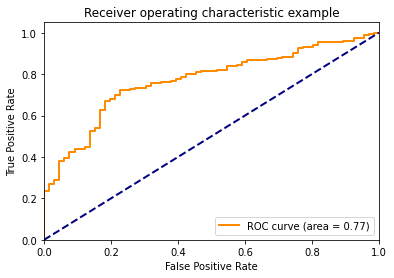

Test Accuracy of the model on test set: 0.46


0.4624927691006986

In [178]:

'''
in_channels=1: because our input is a grayscale image.

Stride: is the number of pixels to pass at a time when sliding the convolutional kernel.

Padding: to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image.

kernel_size: we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

The forward() pass defines the way we compute our output using the given layers and functions.
'''
import torch.nn
from torch import optim
from torch.autograd import Variable

def train(num_epochs, NeuralNet, loaders):
    
    NeuralNet.train()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=10, verbose=True)
    

    total_step = len(loaders['train'])
    _, labs = loaders['train'][:]
    total_step
    print(1-sum(labs[:,0])/total_step)
    print(1-sum(labs[:,1])/total_step)
    print(1-sum(labs[:,2])/total_step)

    # optimizer
    optimizer = optim.Adam(NeuralNet.parameters(), lr = 0.002)   

    # loss
    criterion = nn.MSELoss()#CrossEntropyLoss(weight=torch.tensor([1-sum(labs[:,0])/total_step, 1-sum(labs[:,1])/total_step, 1-sum(labs[:,2])/total_step]))

    # Train the model
    for epoch in range(num_epochs):
        NeuralNet.train()
        print(epoch)
        for images, labels in loaders['train']:
            # clear gradients for this training step   
            optimizer.zero_grad()
            output = NeuralNet(images).to(torch.float64)
            loss = criterion(output, labels.to(torch.float64))
            # print(loss)
            loss.backward()
            optimizer.step()    # Does the update

        # early_stopping needs the validation loss to check if it has decresed, and if it has, it will make a checkpoint of the current model
        NeuralNet.eval()
        test_output = torch.tensor([])
        images, labels = loaders["val"][:]
        with torch.no_grad():
          for imag, labe in loaders['val']:
              test_out = NeuralNet(imag.to(torch.float32))

              test_output = torch.cat((test_output,test_out.unsqueeze(0)),0)

        acc0 = acc_for_class(0,labels, test_output)
        acc1 = acc_for_class(1,labels, test_output)
        acc2 = acc_for_class(2,labels, test_output)
        early_stopping(1-(acc0+acc1+acc2)/3, NeuralNet)
        print("accuracy mean: ", ((acc0+acc1+acc2)/3))
        if early_stopping.early_stop:
            print("Early stopping")
            return early_stopping
        pass
    
    
    pass


def test(model):
    # Test the model
    model.eval()
    test_output = torch.tensor([])
    images, labels = loaders["test"][:]
    with torch.no_grad():
        for imag, labe in loaders['test']:
            test_out = model(imag.to(torch.float32))

            test_output = torch.cat((test_output,test_out.unsqueeze(0)),0)
        
        # save_csv(images,"input") # nicht wirklich gebraucht
        save_csv(test_output,"predictions")
        
        
        strings = to_strings(labels)
        t_np = np.array(strings) #convert to Numpy array
        df = pd.DataFrame(t_np) #convert to a dataframe
        df.to_csv("labels.csv",index=False) #save to file

        acc0 = acc_for_class(0,labels, test_output)
        acc1 = acc_for_class(1,labels, test_output)
        acc2 = acc_for_class(2,labels, test_output)
        print("Hetero acc: ",acc0)
        print("Homo acc: ",acc1)
        print("Sing acc: ",acc2)
        
        import matplotlib.pyplot as plt
        from sklearn.metrics import roc_curve, auc
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(labels[:, i].detach().numpy(), test_output[:, i].detach().numpy())
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(labels.detach().numpy().ravel(), test_output.detach().numpy().ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



        plt.figure()
        lw = 2
        plt.plot(
            fpr[2],
            tpr[2],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[2],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic example")
        plt.legend(loc="lower right")
        plt.show()



    print('Test Accuracy of the model on test set: %.2f' % (1-(acc0+acc1+acc2)/3))
    return (1-(acc0+acc1+acc2)/3)

def acc_of_one_nn_run(NN):
    nnet = NN
    num_epochs = 100
    ES = train(num_epochs, nnet, loaders)

#    print(ES.best_model)


    accuracy = test(ES.best_model)


    # sample = next(iter(loaders['test']))
    # imgs, lbls = sample

    # actual_number = lbls[:10].numpy()
    # actual_number

    # test_output = ES.best_model(imgs[:10].float())
    # pred_y = torch.max(test_output,-1)[1]
    # print(f'Prediction number: {pred_y}')
    # print(f'Actual number: {actual_number}')
    return accuracy


acc_of_one_nn_run(ANNModel(100, 3))


In [181]:
img, lbl = loaders["test"][:]
lbl = to_string(lbl)
print(lbl.count("hetero"))
print(lbl.count("homo"))
print(lbl.count("singlet"))

33
33
1135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [169]:
img, lbl = loaders["train"][0]
print(img.shape)
testnet = ANNModel(102,3)

torch.Size([99])


# Evaluation

In [ ]:
acc_of_one_nn_run(ANNModel, 4,3)

0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
# Create ANN
ACCs = []
ACCs.append(acc_of_one_nn_run(ANNModel, 4,3))
ACCs.append(acc_of_one_nn_run(ANNModel, 4,3))
ACCs.append(acc_of_one_nn_run(ANNModel, 4,3))
ACCs.append(acc_of_one_nn_run(ANNModel, 4,3))
ACCs.append(acc_of_one_nn_run(ANNModel, 4,3))

print("Average accuracy of 5 ANNs: ", np.mean([i for i in ACCs]))



Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre output
forward done
fine
pre o

KeyboardInterrupt: ignored

In [ ]:
# Create CNN
ACCs_c = []
ACCs_c.append(acc_of_one_nn_run(CNN))
ACCs_c.append(acc_of_one_nn_run(CNN))
ACCs_c.append(acc_of_one_nn_run(CNN))
ACCs_c.append(acc_of_one_nn_run(CNN))
ACCs_c.append(acc_of_one_nn_run(CNN))


print("Average accuracy of 5 CNNs: ", np.mean([i for i in ACCs_c]))

count free parameters

In [ ]:


ANN_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(ANN_params)
CNN_params = sum(p.numel() for p in CNN().parameters() if p.requires_grad)
print("Average accuracy of 5 CNNs: ", CNN_params)

648010
28938
